In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm

In [ ]:
class Student():
    def __init__(self):
        pass

    def get_reward(self,action):
        if action == 0:
            score = truncnorm(a=(0-40)/40, b=(100-40)/40, loc=40, scale=40).rvs(size=1).astype(int)
        elif action == 1:
            score = truncnorm(a=(0-60)/10, b=(100-60)/10, loc=60, scale=10).rvs(size=1).astype(int)
        else:
            score = truncnorm(a=(0-50)/20, b=(100-50)/20, loc=50, scale=20).rvs(size=1).astype(int)

        return score

In [ ]:
class Environment:
    def __init__(self, student):
        self.student = student

    def calc_reward(self,action):
        reward = self.student.get_reward(action)
        return reward

In [ ]:
class Gradient_Bandit_agent:
    def __init__(self, env, learning_rate, No_Arms):
      self.num_arms = No_Arms
      self.probs = []
      self.l_r = learning_rate


    def policy(self,pref):
        self.probs = []
        for i in range(self.num_arms):
          self.probs.append(np.exp(pref[i]))
        self.probs = self.probs/np.sum(self.probs)
        return self.probs,pref

    def take_action_get_reward(self,probs):
      action = np.random.choice(self.num_arms,p=self.probs)
      reward = env.calc_reward(action)
      return action,reward

    def update_prefs(self,reward,probs,action,pref,all_rewards,avg_rewards):
      avg_rewards = sum(all_rewards) / len(all_rewards)
      for i in range(self.num_arms):
        if(action==i):
          pref[i]+=self.l_r * (reward-avg_rewards)*(1-probs[i])
        else:
          pref[i]-=self.l_r * (reward-avg_rewards)*(probs[i])
      return pref,avg_rewards


In [ ]:
def iteration(agent,horizon):
  results = []
  results_trials = []
  for j in range(10):
    pref = np.zeros(3)
    actions_trials = np.zeros(3)
    all_rewards = []
    trial_each_horizon = []
    avg_rewards = 0
    for i in range(horizon):
      [probs,pref] = agent.policy(pref)
      [action,reward] = agent.take_action_get_reward(probs)
      actions_trials[action]+=1
      all_rewards.append(reward)
      trial_each_horizon.append(actions_trials.copy())
      [pref,avg_rewards] = agent.update_prefs(reward,probs,action,pref,all_rewards,avg_rewards)
    results_trials.append(trial_each_horizon)
    results.append(all_rewards)
  return results_trials,results

In [ ]:
def reward(results,horizon):
  upper_bound = []
  lower_bound = []
  horizon_reward  = []
  for m in range(horizon):
    temp_horizon = 0
    temp_reward = []
    for k in range(10):
      temp_horizon+= results[k][m]
      temp_reward.append(results[k][m])
    std = (sum((temp_reward-temp_horizon/10)**2) / 10)**0.5
    upper = temp_horizon/10 + 3*std
    lower = temp_horizon/10 - 3*std
    upper_bound.append(upper)
    lower_bound.append(lower)
    temp_horizon = temp_horizon/10
    horizon_reward.append(temp_horizon)
  upper_bound = [element[0] for element in upper_bound]
  lower_bound = [element[0] for element in lower_bound]
  return horizon_reward,lower_bound,upper_bound


def regret(results_trials,horizon):
  regret_horizon = []
  upper_bound = []
  lower_bound = []
  delta_i = [20,0,10]
  for j in range(horizon):
    temp_sum = 0
    temp_list = []
    for i in range(10):
      temp_sum+=results_trials[i][j]
      temp_list.append(results_trials[i][j])
    std = (sum((temp_list-temp_sum/10)**2) / 10)**0.5
    upper = temp_sum/10 + 1.96*std/np.sqrt(10)
    lower = temp_sum/10 - 1.96*std/np.sqrt(10)
    upper_bound.append(np.dot(delta_i,upper))
    lower_bound.append(np.dot(delta_i,lower))
    regret_horizon.append(np.dot(delta_i,temp_sum/10))
  return regret_horizon,lower_bound,upper_bound

In [ ]:
def plot_reward(horizon_reward,lower_reward,upper_reward,legend,label_conf):
  fig, ax = plt.subplots()
  ax.plot(horizon_reward, label=legend)
  ax.fill_between(np.arange(len(horizon_reward)), lower_reward ,upper_reward , alpha=0.5, label=label_conf)
  ax.set_xlabel("Trial")
  ax.set_ylabel("Reward")
  ax.set_title("Regret with Confidence Bound 3 Std")
  plt.legend()
  plt.show()



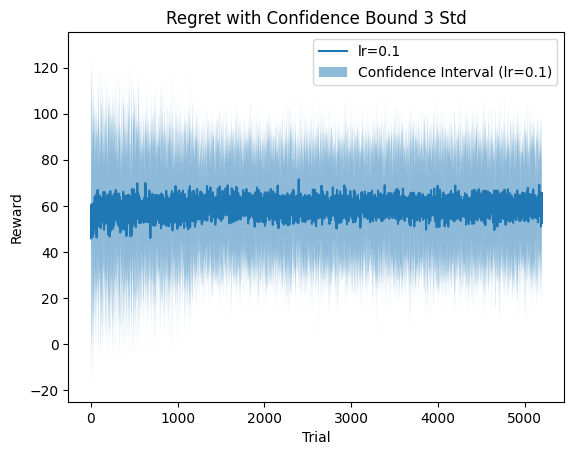

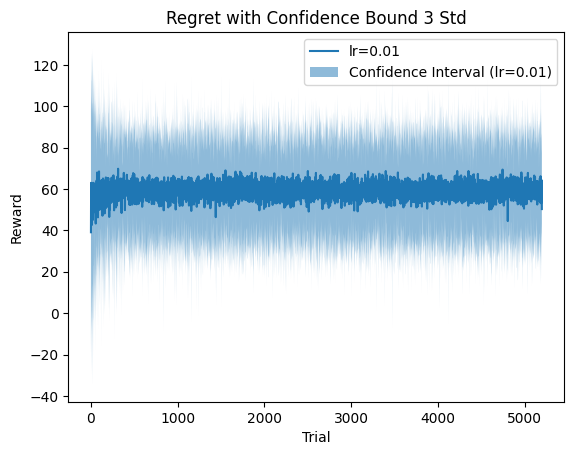

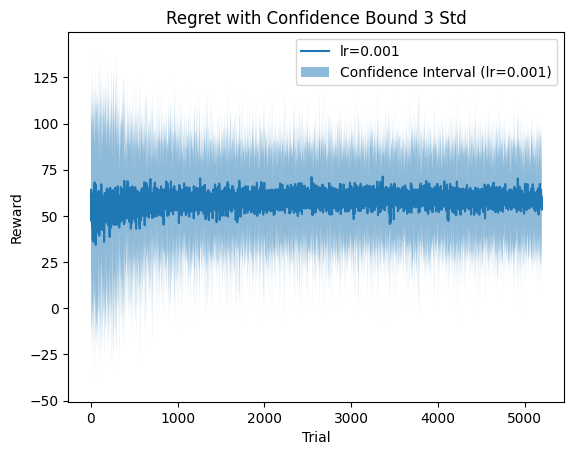

In [ ]:
std = Student()
env = Environment(std)
learning_rates = [0.1,0.01,0.001]
legends = ['lr=0.1','lr=0.01','lr=0.001']
horizon = 5200
regrets = []
for i, lr in enumerate(learning_rates):

  agent = Gradient_Bandit_agent(env,lr,3)
  [results_trials, results] = iteration(agent, horizon)
  [regret_horizon,lower_regret,upper_regret] = regret(results_trials, horizon)
  [horizon_reward,lower_reward,upper_reward] = reward(results,horizon)
  regrets.append([regret_horizon,lower_regret,upper_regret])
  label_conf = f"Confidence Interval (lr={lr})"
  plot_reward(horizon_reward,lower_reward,upper_reward,legends[i],label_conf)

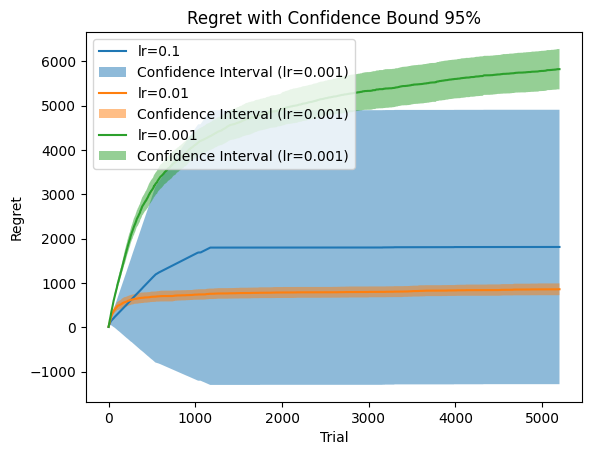

In [ ]:
fig, ax = plt.subplots()
legends = ['lr=0.1','lr=0.01','lr=0.001']
for i in range(3):
  regret_horizon = regrets[i][0]
  lower_bound = regrets[i][1]
  upper_bound = regrets[i][2]
  label_conf = f"Confidence Interval (lr={lr})"
  ax.plot(regret_horizon, label=legends[i])
  ax.fill_between(np.arange(len(regret_horizon)), lower_bound ,upper_bound , alpha=0.5, label=label_conf)

ax.set_xlabel("Trial")
ax.set_ylabel("Regret")
ax.set_title("Regret with Confidence Bound 95%")
ax.legend(fontsize='small', markerscale=0.1)
ax.legend()
plt.show()